In [1]:
import tensorflow as tf
import keras 
from tensorflow.keras import models , layers 
import matplotlib.pyplot as plt
import numpy as np


In [4]:
IMG_SZE=256
BATCH_SZE=32
CHANNELS=3

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size=(IMG_SZE,IMG_SZE),
    batch_size=BATCH_SZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

In [8]:
for image ,label in dataset.take(1):
    print(image.shape)
    print(label.numpy())

(32, 256, 256, 3)
[0 1 1 0 1 0 0 0 1 1 2 0 1 0 2 0 0 1 1 0 1 1 0 1 1 1 1 0 2 0 0 1]


### SPLIT DA DATA

In [9]:
train_ds = dataset.take(round(len(dataset)*0.8))
len(train_ds)

54

In [10]:
test_ds = dataset.skip(round(len(dataset)*0.2))
len(test_ds)

54

In [11]:
def get_patrion(ds,train_split= 0.8,val_split = 0.1 , test_split = 0.1 , shuffle=True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle :
        ds=ds.shuffle(shuffle_size,seed=43)
    train_size = round(len(dataset)*train_split)
    test_size = round(len(dataset)*test_split)
    val_size = round(len(dataset)*val_split)
                     
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [12]:
train,val,test = get_patrion(dataset)

In [13]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_scalling = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SZE,IMG_SZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(45)
])

In [16]:
input_shape = (BATCH_SZE,IMG_SZE,IMG_SZE,CHANNELS)
def leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=0.2)
net = models.Sequential([
    resize_and_scalling,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation=leaky_relu,input_shape =input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation=leaky_relu),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation=leaky_relu),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation=leaky_relu),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation=leaky_relu),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(3,activation='softmax')
]
)
net.build(input_shape = input_shape)

In [17]:
net.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [18]:
net.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [19]:
history =net.fit(
    train,
    epochs = 30 ,
    batch_size=BATCH_SZE,
    verbose=1,
    validation_data = val
)

Epoch 1/30
54/54 [==============================] - 19s 196ms/step - loss: 0.9058 - accuracy: 0.5052 - val_loss: 0.7615 - val_accuracy: 0.7098
Epoch 2/30
54/54 [==============================] - 10s 177ms/step - loss: 0.5683 - accuracy: 0.7720 - val_loss: 0.4440 - val_accuracy: 0.8170
Epoch 3/30
54/54 [==============================] - 10s 176ms/step - loss: 0.3976 - accuracy: 0.8397 - val_loss: 0.4237 - val_accuracy: 0.8527
Epoch 4/30
54/54 [==============================] - 10s 178ms/step - loss: 0.3091 - accuracy: 0.8709 - val_loss: 0.2255 - val_accuracy: 0.9152
Epoch 5/30
54/54 [==============================] - 10s 178ms/step - loss: 0.2898 - accuracy: 0.8866 - val_loss: 0.2015 - val_accuracy: 0.9286
Epoch 6/30
54/54 [==============================] - 10s 177ms/step - loss: 0.1992 - accuracy: 0.9294 - val_loss: 0.1737 - val_accuracy: 0.9241
Epoch 7/30
54/54 [==============================] - 10s 178ms/step - loss: 0.1533 - accuracy: 0.9387 - val_loss: 0.3530 - val_accuracy: 0.8795

In [20]:
gpus = tf.config.list_physical_devices("GPU")

In [21]:
if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)
else:
    print("Failed to detect a GPU.")

Found a GPU with the name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [22]:
score = net.evaluate(test)

7/7 [==============================] - 1s 54ms/step - loss: 0.0621 - accuracy: 0.9600


In [23]:
score

[0.06210976466536522, 0.9599999785423279]

In [24]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'I dunno man')

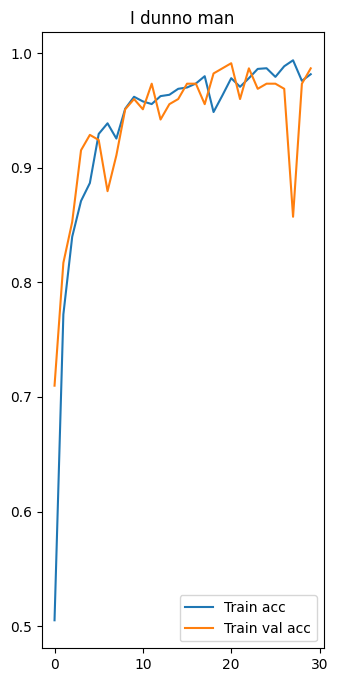

In [27]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(30),acc,label = 'Train acc')
plt.plot(range(30),val_acc , label = 'Train val acc')
plt.legend(loc='lower right')
plt.title("I dunno man")

first imag to predict
actual label :  Potato___Early_blight
1/1 [==============================] - 0s 83ms/step
model predict:  Potato___Early_blight


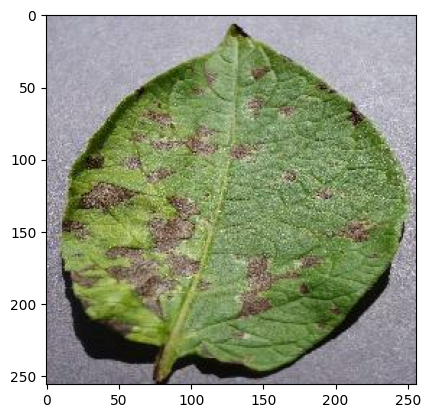

In [28]:
for img , lab in test.take(1):
    first_img = img[0].numpy().astype('uint8')
    first_lab = lab[0].numpy()
    print('first imag to predict')
    plt.imshow(first_img)
    print('actual label : ',class_names[first_lab])
    predict = net.predict(img)
    print('model predict: ' , class_names[np.argmax(predict[0])])

In [32]:
model_style = 2
net.save(f"../models/model_{model_style}.keras",)